In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import IPython
import matplotlib.pyplot as plt
from librosa.core.audio import resample
import numpy as np
import soundfile as sf
import time
from tqdm import tqdm

from nara_wpe import wpe
from nara_wpe.utils import stft, istft, get_stft_center_frequencies
from nara_wpe import project_root

In [2]:
stft_options = dict(
    size=1024,
    shift=256,
    window_length=None,
    fading=True,
    pad=True,
    symmetric_window=False
)

# Minimal example with random data

In [3]:
def aquire_audio_data():
    D, T = 4, 10000
    y = np.random.normal(size=(D, T))
    return y

In [4]:
y = aquire_audio_data()
Y = stft(y, **stft_options)
Y = Y.transpose(2, 0, 1)

start = time.perf_counter()
Z = wpe.wpe(Y)
end = time.perf_counter()

z_np = istft(Z.transpose(1, 2, 0))
print(f"Time: {end-start}")

Time: 0.4642430520034395


# Example with real audio recordings

### Setup

In [5]:
channels = 8
sampling_rate = 16000
stft_options.update(size=512, shift=128)
delay = 3
iterations = 5
K = 10

### Audio data

In [6]:
file_template = 'AMI_WSJ20-Array1-{}_T10c0201.wav'
signal_list = [
    sf.read(str(project_root / 'data' / file_template.format(d + 1)))[0]
    for d in range(channels)
]
y = np.stack(signal_list, axis=0)
IPython.display.Audio(y[0], rate=sampling_rate)

### Result

In [12]:
Y = stft(y, **stft_options)
Z = wpe.wpe_v8(Y.transpose(2, 0, 1)).transpose(1, 2, 0)

z = istft(Z, size=stft_options['size'], shift=stft_options['shift'])

IPython.display.Audio(z[0], rate=sampling_rate)

(8, 127523)
(8, 1000, 257)


### Iterative

In [8]:
X = np.copy(Y)
D, T, F = Y.shape
for f in tqdm(range(F), total=F):
    X[:, :, f] = wpe.wpe_v8(Y[None, :, :, f], K=K, delay=delay, iterations=iterations)[0]

x = istft(X, size=stft_options['size'], shift=stft_options['shift'])
IPython.display.Audio(z[0], rate=sampling_rate)

100%|██████████| 257/257 [00:05<00:00, 45.43it/s]


### Resampled

In [9]:
signal_list = [resample(x_, 16000, sampling_rate) for x_ in signal_list]
y = np.stack(signal_list, axis=0)
Y = stft(y, **stft_options)

X = np.copy(Y)
D, T, F = Y.shape
for n in tqdm(range(1), total=1):
    X = wpe.wpe_v8(Y.transpose((2, 0, 1)), K=K, delay=delay, iterations=iterations).transpose(1, 2, 0)

x = istft(X, size=stft_options['size'], shift=stft_options['shift'])

100%|██████████| 1/1 [00:05<00:00,  5.27s/it]


## PSD

(8, 1000, 257) (8, 1000, 257)


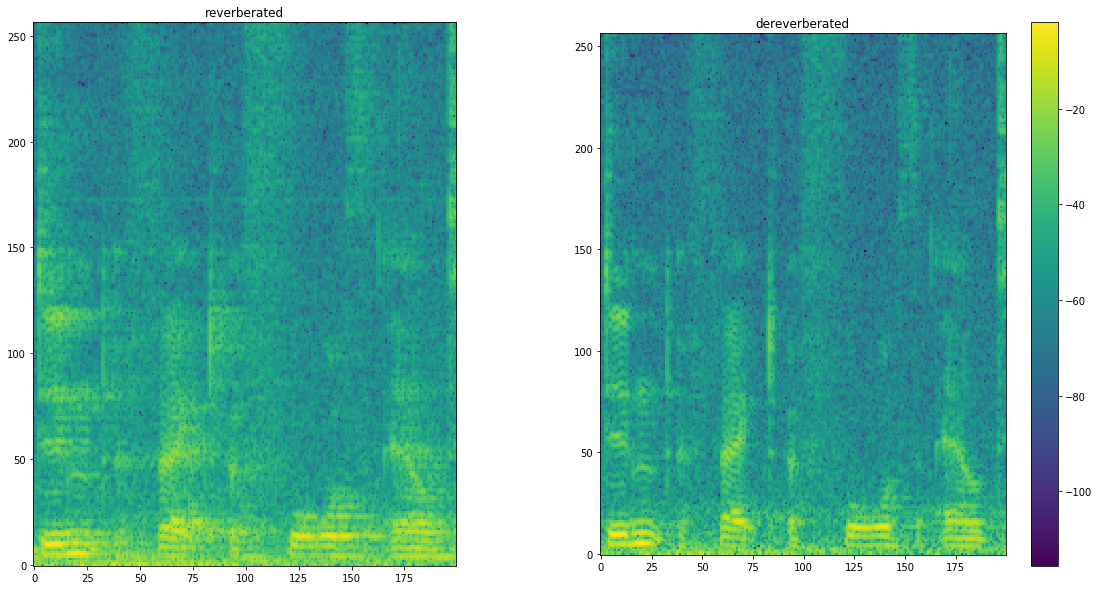

In [10]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
im1 = ax1.imshow(20 * np.log10(np.abs(Y[0, 200:400, :])).T, origin='lower')
ax1.set_xlabel('')
_ = ax1.set_title('reverberated')
im2 = ax2.imshow(20 * np.log10(np.abs(Z[0, 200:400, :])).T, origin='lower')
_ = ax2.set_title('dereverberated')
cb = fig.colorbar(im1)